# Modeling and Simulation in Python

Chapter 18

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code from the previous chapter

Read the data.

In [2]:
data = pd.read_csv('data/glucose_insulin.csv', index_col='time');

Interpolate the insulin data.

In [3]:
I = interpolate(data.insulin)

<function modsim.modsim.interpolate.<locals>.wrapper(x)>

Initialize the parameters

In [4]:
G0 = 290
k1 = 0.03
k2 = 0.02
k3 = 1e-05

1e-05

To estimate basal levels, we'll use the concentrations at `t=0`.

In [5]:
Gb = data.glucose[0]
Ib = data.insulin[0]

11

Create the initial condtions.

In [6]:
init = State(G=G0, X=0)

,values
G,290
X,0


Make the `System` object.

In [7]:
t_0 = get_first_label(data)
t_end = get_last_label(data)

182

In [8]:
system = System(G0=G0, k1=k1, k2=k2, k3=k3,
                init=init, Gb=Gb, Ib=Ib, I=I,
                t_0=t_0, t_end=t_end, dt=2)

,values
G0,290
k1,0.03
k2,0.02
k3,1e-05
init,G 290 X 0 dtype: int64
Gb,92
Ib,11
I,<function interpolate.<locals>.wrapper at 0x7f...
t_0,0
t_end,182


In [9]:
def update_func(state, t, system):
    """Updates the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: State object
    """
    G, X = state
    k1, k2, k3 = system.k1, system.k2, system.k3 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    dt = system.dt
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

In [10]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

In [11]:
results = run_simulation(system, update_func);

### Numerical solution

In the previous chapter, we approximated the differential equations with difference equations, and solved them using `run_simulation`.

In this chapter, we solve the differential equation numerically using `run_ode_solver`, which is a wrapper for the SciPy ODE solver.

Instead of an update function, we provide a slope function that evaluates the right-hand side of the differential equations.  We don't have to do the update part; the solver does it for us.

In [12]:
def slope_func(state, t, system):
    """Computes derivatives of the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: derivatives of G and X
    """
    G, X = state
    k1, k2, k3 = system.k1, system.k2, system.k3 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

We can test the slope function with the initial conditions.

In [13]:
slope_func(init, 0, system)

(-5.9399999999999995, 0.0)

Here's how we run the ODE solver.

In [14]:
results2, details = run_ode_solver(system, slope_func, t_eval=data.index);

`details` is a `ModSimSeries` object with information about how the solver worked.

In [15]:
details

,values
success,True
message,The solver successfully reached the end of the...


`results` is a `TimeFrame` with one row for each time step and one column for each state variable:

In [16]:
results2

,G,X
0,290,0
2,278.476,0.00015
4,267.464,0.00147812
6,255.899,0.00330258
8,244.424,0.00428352
10,233.421,0.0048796
12,222.905,0.00539312
14,212.909,0.00580811
16,203.454,0.00610843
18,194.566,0.00630605


Plotting the results from `run_simulation` and `run_ode_solver`, we can see that they are not very different.

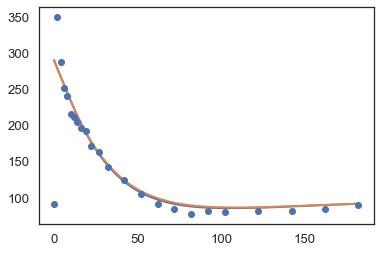

In [17]:
plot(results.G, '-')
plot(results2.G, '-')
plot(data.glucose, 'bo')

The differences in `G` are less than 1%.

In [18]:
diff = results.G - results2.G
percent_diff = diff / results2.G * 100
percent_diff.dropna()

0              0
2      -0.127982
4      -0.191302
6       0.154946
8        0.26436
10      0.207439
12      0.132947
14      0.035413
16    -0.0815439
18     -0.222312
20     -0.371789
22     -0.522334
24     -0.664226
26     -0.801867
28     -0.934267
30      -1.05701
32       -1.1642
34      -1.25663
36        -1.346
38      -1.43135
40       -1.5119
42      -1.58699
44      -1.65612
46      -1.71812
48      -1.77288
50      -1.82036
52      -1.86066
54      -1.89392
56      -1.91501
58      -1.92508
         ...    
124    -0.661724
126    -0.631811
128    -0.601917
130    -0.572193
132     -0.54277
134    -0.513756
136    -0.485244
138    -0.457312
140    -0.430024
142    -0.403431
144    -0.377577
146    -0.352881
148    -0.329311
150    -0.306834
152    -0.285416
154    -0.265021
156    -0.245616
158    -0.227165
160    -0.209635
162    -0.192991
164    -0.177201
166     -0.16262
168    -0.149158
170    -0.136734
172     -0.12527
174    -0.114695
176    -0.104943
178   -0.09595

### Optimization

Now let's find the parameters that yield the best fit for the data.  

We'll use these values as an initial estimate and iteratively improve them.

In [19]:
params = Params(G0 = 290,
                k1 = 0.03,
                k2 = 0.02,
                k3 = 1e-05)

,values
G0,290.00000
k1,0.03000
k2,0.02000
k3,0.00001


`make_system` takes the parameters and actual data and returns a `System` object.

In [20]:
def make_system(params, data):
    """Makes a System object with the given parameters.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: System object
    """
    # params might be a Params object or an array,
    # so we have to unpack it like this
    G0, k1, k2, k3 = params
    
    Gb = data.glucose[0]
    Ib = data.insulin[0]
    I = interpolate(data.insulin)
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)

    init = State(G=G0, X=0)
    
    return System(G0=G0, k1=k1, k2=k2, k3=k3,
                  init=init, Gb=Gb, Ib=Ib, I=I,
                  t_0=t_0, t_end=t_end, dt=2)

In [21]:
system = make_system(params, data)

,values
G0,290
k1,0.03
k2,0.02
k3,1e-05
init,G 290.0 X 0.0 dtype: float64
Gb,92
Ib,11
I,<function interpolate.<locals>.wrapper at 0x7f...
t_0,0
t_end,182


`error_func` takes the parameters and actual data, makes a `System` object, and runs `odeint`, then compares the results to the data.  It returns an array of errors.

In [22]:
system = make_system(params, data)
results, details = run_ode_solver(system, slope_func, t_eval=data.index)
details

,values
success,True
message,The solver successfully reached the end of the...


In [23]:
def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    data: DataFrame of values to be matched
    
    returns: array of errors
    """
    print(params)
    
    # make a System with the given parameters
    system = make_system(params, data)
    
    # solve the ODE
    results, details = run_ode_solver(system, slope_func, t_eval=data.index)
    
    # compute the difference between the model
    # results and actual data
    errors = results.G - data.glucose
    return errors

When we call `error_func`, we provide a sequence of parameters as a single object.

Here's how that works:

In [24]:
error_func(params, data)

G0    290.00000
k1      0.03000
k2      0.02000
k3      0.00001
dtype: float64


0      198.000000
2      -71.523600
4      -19.535535
6        4.898956
8        4.423982
10      17.420932
12      11.905305
14       7.909446
16       7.454111
18            NaN
19            NaN
20            NaN
22       6.458757
24            NaN
26            NaN
27            NaN
28            NaN
30            NaN
32       4.670366
34            NaN
36            NaN
38            NaN
40            NaN
42       0.314528
44            NaN
46            NaN
48            NaN
50            NaN
52       4.166524
54            NaN
          ...    
124           NaN
126           NaN
128           NaN
130           NaN
132           NaN
134           NaN
136           NaN
138           NaN
140           NaN
142      6.365824
144           NaN
146           NaN
148           NaN
150           NaN
152           NaN
154           NaN
156           NaN
158           NaN
160           NaN
162      5.142209
164           NaN
166           NaN
168           NaN
170           NaN
172       

`leastsq` is a wrapper for `scipy.optimize.leastsq`

Here's how we call it.

In [25]:
best_params, fit_details = leastsq(error_func, params, data)

[2.9e+02 3.0e-02 2.0e-02 1.0e-05]
[2.9e+02 3.0e-02 2.0e-02 1.0e-05]
[2.9e+02 3.0e-02 2.0e-02 1.0e-05]
[2.90000004e+02 3.00000000e-02 2.00000000e-02 1.00000000e-05]
[2.90000000e+02 3.00000004e-02 2.00000000e-02 1.00000000e-05]
[2.90000000e+02 3.00000000e-02 2.00000003e-02 1.00000000e-05]
[2.90000000e+02 3.00000000e-02 2.00000000e-02 1.00000001e-05]


The first return value is a `Params` object with the best parameters:

In [26]:
best_params

,values
G0,290.00000
k1,0.03000
k2,0.02000
k3,0.00001


The second return value is a `ModSimSeries` object with information about the results.

In [27]:
fit_details

,values
fvec,"[198.0, -71.52359999999999, -19.53553501808568..."
nfev,5
fjac,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
ipvt,"[1, 2, 3, 4]"
qtf,"[nan, nan, nan, nan]"
cov_x,None
mesg,The cosine of the angle between func(x) and an...
ier,4


Now that we have `best_params`, we can use it to make a `System` object and run it.

In [28]:
system = make_system(best_params, data)
results, details = run_ode_solver(system, slope_func, t_eval=data.index)
details.message

'The solver successfully reached the end of the integration interval.'

Here are the results, along with the data.  The first few points of the model don't fit the data, but we don't expect them to.

Saving figure to file figs/chap08-fig04.pdf


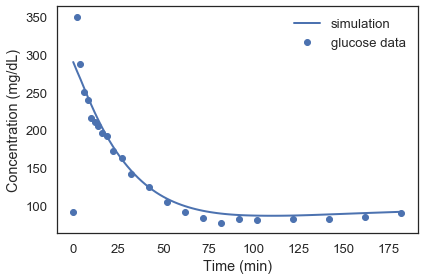

In [29]:
plot(results.G, label='simulation')
plot(data.glucose, 'bo', label='glucose data')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

savefig('figs/chap08-fig04.pdf')

### Interpreting parameters

Based on the parameters of the model, we can estimate glucose effectiveness and insulin sensitivity.

In [30]:
def indices(params):
    """Compute glucose effectiveness and insulin sensitivity.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: State object containing S_G and S_I
    """
    G0, k1, k2, k3 = params
    return State(S_G=k1, S_I=k3/k2)

Here are the results.

In [31]:
indices(best_params)

,values
S_G,0.0300
S_I,0.0005


### Under the hood

Here's the source code for `run_ode_solver` and `leastsq`, if you'd like to know how they work.

In [32]:
source_code(run_ode_solver)

def run_ralston(system, slope_func, **options):
    """Computes a numerical solution to a differential equation.

    `system` must contain `init` with initial conditions,
     and `t_end` with the end time.

     `system` may contain `t_0` to override the default, 0

    It can contain any other parameters required by the slope function.

    `options` can be ...

    system: System object
    slope_func: function that computes slopes

    returns: TimeFrame
    """
    # the default message if nothing changes
    msg = "The solver successfully reached the end of the integration interval."

    # get parameters from system
    init, t_0, t_end, dt = check_system(system, slope_func)

    # make the TimeFrame
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt) * get_units(t_end)

    event_func = options.get('events', None)
    z1 = np.nan

    def project(y1, t1, slopes, dt):
        t2 = t1 + dt
        y2 = [y + slope * dt for y, slop

In [33]:
source_code(leastsq)

def leastsq(error_func, x0, *args, **options):
    """Find the parameters that yield the best fit for the data.

    `x0` can be a sequence, array, Series, or Params

    Positional arguments are passed along to `error_func`.

    Keyword arguments are passed to `scipy.optimize.leastsq`

    error_func: function that computes a sequence of errors
    x0: initial guess for the best parameters
    args: passed to error_func
    options: passed to leastsq

    :returns: Params object with best_params and ModSimSeries with details
    """
    # override `full_output` so we get a message if something goes wrong
    options['full_output'] = True

    # run leastsq
    t = scipy.optimize.leastsq(error_func, x0=x0, args=args, **options)
    best_params, cov_x, infodict, mesg, ier = t

    # pack the results into a ModSimSeries object
    details = ModSimSeries(infodict)
    details.set(cov_x=cov_x, mesg=mesg, ier=ier)

    # if we got a Params object, we should return a Params object
    if is

## Exercises

**Exercise:** Since we don't expect the first few points to agree, it's probably better not to make them part of the optimization process.  We can ignore them by leaving them out of the `Series` returned by `error_func`.  Modify the last line of `error_func` to return `errors.loc[8:]`, which includes only the elements of the `Series` from `t=8` and up.

Does that improve the quality of the fit?  Does it change the best parameters by much?

Note: You can read more about this use of `loc` [in the Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-integer).

**Exercise:** How sensitive are the results to the starting guess for the parameters?  If you try different values for the starting guess, do we get the same values for the best parameters?

**Related reading:** You might be interested in this article about [people making a DIY artificial pancreas](https://www.bloomberg.com/news/features/2018-08-08/the-250-biohack-that-s-revolutionizing-life-with-diabetes).